# Chapter 10 - Testing

Recall the "Euro Problem": A Euro coin was spun, and 140 times it came up Heads to 110 Tails. Earlier we tried to solve the problem of whether it was biased by creating a posterior distribution for the probability of getting Heads and constructing a credible interval. 

## Estimation

Solution from last time

<AxesSubplot:>

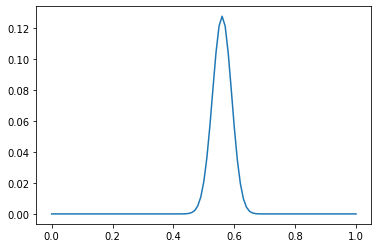

In [1]:
import numpy as np
from empiricaldist import Pmf
from scipy.stats import binom

xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)
k, n = 140, 250 # k = number of heads; n is the total number
likelihood = binom.pmf(k, n, xs)

posterior = uniform * likelihood
posterior.normalize()
posterior.plot()

In [2]:
posterior.mean(), posterior.credible_interval(0.9)

(0.5595238095238094, array([0.51, 0.61]))

So the mean increased (from 50% to 56%), and the credible interval excludes 50%, so...

## Evidence

Recall from "Oliver's Blood" that data is considered evidence for a hypothesis A if the data is more likely to happen given A than given the alternative, B.

$$
P(D|A) > P(D|B)
$$

We can quantify this by using the ratio, also called the Bayes' Factor:

$$
K = \frac{P(D|A)}{P(D|B)}
$$

Let's take a look at this using two hypotheses: `fair` and `biased`.

In [3]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_biased = binom.pmf(k, n, p=0.56) # Why was this chosen as the probability for `biased`? Arbitrary!
K = like_biased / like_fair
K

6.075990838368465

So the data are about 6 times as likely if the coin is biased (in that way) than if it were unbiased.

## Uniformly Distributed Bias

Let's say that biased means "Anything other than 50%, with all other values equally likely"

In [4]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

100

To compute the total probability of the data under this hypothesis, we compute the conditional probability of the data for each value of $x$ (the probability of flipping Heads).

In [5]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)
biased_posterior = biased_uniform * likelihood
like_uniform = np.sum(biased_posterior)
like_uniform

0.003900491927770735

In [6]:
K = like_fair / like_uniform
K

2.1425968518013625

We can use Bayes' Rule to see how strong the evidence is. Let's assume that a priori, there is a 50% chance that the coin is biased:

In [7]:
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

2.1425968518013625

In [8]:
def prob(o):
    return o / (o + 1)
prob(posterior_odds)

0.6817918278551092

Evidence that 'moves the needle' from 50% to 68% is not very strong (supposedly).

Now suppose that biased means that values are near 50% are more likely, but that 50% exactly is impossible.

<AxesSubplot:>

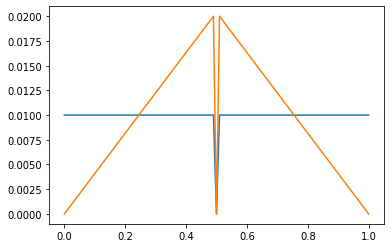

In [9]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)
triangle = Pmf(a, xs, name="triangle")
triangle.normalize()
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()
biased_uniform.plot()
biased_triangle.plot()

### Exercise 10-1
> Now compute the total probability of the data under this definition of biased compute the Bayes factor, compared with the fair hypothesis. The the data evidence that the coin is biased?

In [10]:
### Solution

posterior_triangle = biased_triangle * binom.pmf(k, n, biased_triangle.qs)
like_triangle = np.sum(posterior_triangle)

In [11]:
K = like_triangle / like_fair
K

0.8353683926774023

So this data is very weak evidence in favour of the idea that it is fair.

### Bayesian Hypothesis Testing

This is Bayesian Hypothesis testing! Some people think that it is better to report $K$ than the posterior distribution, since it doesn't rely on the priors. However, as you can see, it does depend very strongly on the choice of hypotheses, so...

## Bayesian Bandits

Slot machine: one-armed bandit

Say there are some slot machines in front of you, and each has some probability of paying out each time that you pull the arm. Initially you have no reason to prefer one over the other, but as you begin to play you gain information about which one is the better bet...

## Prior Beliefs

Initially we know nothing: prior beliefs about the probability -> uniform. Say that there are four machines.

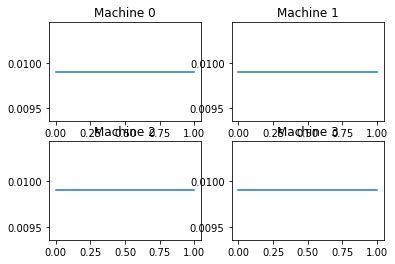

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2)

possible_ps = np.linspace(0, 1, 101)
prior = Pmf(1, possible_ps)
prior.normalize()

beliefs = [prior.copy() for _ in range(4)]
for i in range(2):
    for j in range(2):
        axes[i, j].plot(beliefs[2*i + j])
        axes[i, j].set_title( f"Machine {2*i + j}")
        
def plot_distros(beliefs):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
    for i in range(2):
        for j in range(2):
            axes[i, j].plot(beliefs[2*i + j])
            axes[i, j].set_title( f"Machine {2*i + j}")
            axes[i, j].label_outer()
    

## The Update

Every time that we update a machine, we use the outcome to update our beliefs:

<AxesSubplot:>

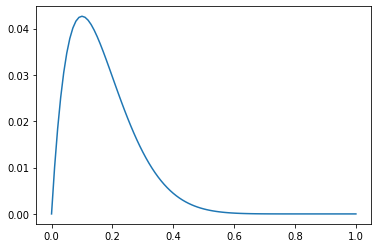

In [13]:
likelihood = {
    'W': possible_ps,
    'L': 1 - possible_ps
}

def update(pmf, data):
    pmf *= likelihood[data]
    pmf.normalize()

bandit = prior.copy()
for outcome in "W" + 9 * "L":
    update(bandit, outcome)
bandit.plot()

## Multiple Bandits

Now suppose that we have four machines with these probabilities:

In [14]:
actual_probs = [0.1, 0.2, 0.3, 0.4]

The following takes the index of a machine, simulates playing the machine once, and returns the outcome, W or L.

In [15]:
from collections import Counter

# count how many times we've played each machine
counter = Counter()

def play(i):
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

(`Counter()` is a kind of dictionary)

here is a test run of playing each machine ten times

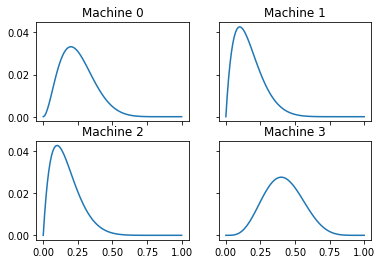

In [16]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)
plot_distros(beliefs)

Here are the actual probabilities, posterior means, and 90% credible intervals:

In [17]:
import pandas as pd

df = pd.DataFrame()
df['Actual'] = actual_probs
df['Posterior Mean'] = [ dist.mean() for dist in beliefs ]
df['90% CI'] = [ dist.credible_interval(0.9) for dist in beliefs ]
df

,Actual,Posterior Mean,90% CI
0,0.1,0.250000,"[0.08, 0.47000000000000003]"
1,0.2,0.166819,"[0.03, 0.36]"
2,0.3,0.166819,"[0.03, 0.36]"
3,0.4,0.416667,"[0.2, 0.65]"


## Explore and Exploit

Based on this (data only), which one would you want to play? A reasonable approach would be the one with the highest mean; however, this runs the risk of choosing one (with little initial data) and playing that one exclusively, missing out on one with a higher $p$ that got unlucky.

Another approach: play all of them until we have some pre-determined level of confidence that we know the best one. However, that approach means that we will end up playing some machines that we are pretty confident are low-$p$.

The Bayesian Bandits strategy avoids both of these by using *Thompson sampling* to both explore (gather data) and exploit (get the best payoff) at the same time. The idea is that we choose a random machine so that the probability of choosing each machine is proportional to the probability that it is the best.

Given the posterior distributions, we can compute the "probability of superiority" as follows:

In [18]:
samples = np.array([b.choice(1000) for b in beliefs])
samples.shape

(4, 1000)

So here are 1000 cases of drawing one sample from each machine. Now we'll see in every draw, which machine yielded the highest value (remember: of $p$)

In [19]:
indices = np.argmax(samples, axis=0)
indices.shape

(1000,)

In [20]:
pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.151
1,0.042
2,0.058
3,0.749


These fractions approximate the probability that the machine is superior!

In [21]:
def choose(beliefs):
    """ 
    Use Thompson sampling to choose a machine
    
    Draws a single sample from each distribution
    
    Returns:
        Index of the machine that yielded the highest value
    """
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

## The Strategy

The following function chooses a machine, plays once, and updates `beliefs`.

In [22]:
def choose_play_update(beliefs):
    """ Choose a machine, play it, and update out beliefs """
    
    machine = choose(beliefs)
    
    outcome = play(machine)
    
    update(beliefs[machine], outcome)

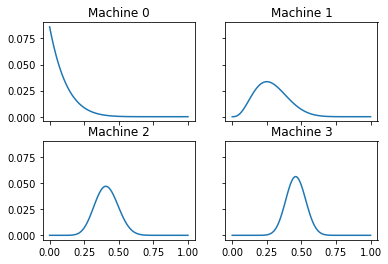

In [23]:
# Fresh game

beliefs = [prior.copy() for i in range(4)]
counter = Counter()

# Let's run it 100 times
num_plays = 100
for i in range(num_plays):
    choose_play_update(beliefs)

plot_distros(beliefs)

This tends to play the higher-percentage machines more and the lower-$p$ machines less, which is basically exactly what we want.

## Exercises

### Exercise 10-2
> Adaptive tests - as the students get questions right (or wrong), give them harder or easier questions depending on how they did on previous ones. This has the potential to make more "efficient" tests, in that we have a more accurate estimate of their ability using the same number of questions.
>
> We'll use [Item response theory](https://en.wikipedia.org/wiki/Item_response_theory), which states that test-takers have some level of skill and the questions have some level of difficulty, and that the probability of a student getting an answer correct is a function of their skill and the question's difficulty.
> 
> A common assumption is that the function is a 3-parameter logistic function:
> 
>$$
 P = c + \frac{1-c}{1+e^{-a(\theta - b)}}
>$$
> - $\theta$: skill of the test-taker
> - $b$: difficulty of the question
> - $c$: probability of the least skilled test-taker answering the most difficult question (e.g. for a multiple choice test it might be 0.25 - the probability of getting it right based on guesswork)

In [24]:
### Solution

In [25]:
def prob_correct(ability, difficulty):
    """ Given the ability and difficulty, calculate the probability of getting the question correct """
    a = 100
    c = 0.25
    x = (ability - difficulty) / a
    p = c + (1 - c) / (1 + np.exp(-x))
    return p

# (value of a chosen so that it mirrors the SAT)

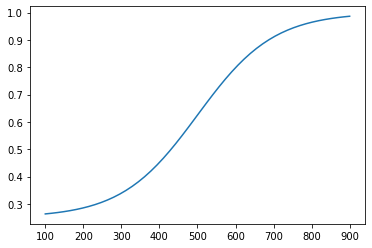

In [26]:
# Here's what the probabilities look like
diff = 500
abilities = np.linspace(100, 900)
ps = prob_correct(abilities, diff)
plt.plot(abilities, ps)

## Simulating the Test
We'll use the same strategy as for the Bayesian Bandit:
- A function `play` that simulates a test-taker answering one question
- A function `choose` that chooses the next question to pose
- A function `update` that uses the outcome (a correct response, or not) to update the estimate of the test-taker's ability

In [27]:
def play(ability, difficulty):
    """ Simulates one test-taker answering one question """
    p = prob_correct(ability, difficulty)
    return np.random.random() < p

prob_correct(600, 500)

0.7982939339725037

In [28]:
# result of one simulation of this student taking a 51-question test, all of difficulty 500
num_questions = 51
results = [ play(600, 500) for _ in range(num_questions) ]
np.mean(results)

0.8627450980392157

## The Prior
SAT is designed so that the distribution of scores is roughly distributed as a normal distribution with mean 500 and sd 100. However, we are going to artificially inflate the sd -> 300 so that we avoid cutting off the tails.

In [29]:
from scipy.stats import norm

mean = 500
std = 300
qs = np.linspace(0, 1000)
ps = norm(mean, std).pdf(qs)
prior = Pmf(ps, qs)
prior.normalize()

0.04464186995102338

<AxesSubplot:>

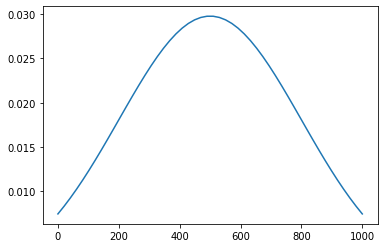

In [30]:
prior.plot()

651.2097726211696


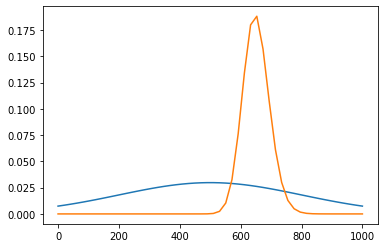

In [31]:
def update_ability(pmf, data):
    """ Update the distribution of the ability """
    difficulty, outcome = data
    
    abilities = pmf.qs
    ps = prob_correct(abilities, difficulty)
    
    if outcome:
        pmf *= ps
    else:
        pmf *= 1 - ps
    
    pmf.normalize()
    
actual_600 = prior.copy()
for outcome in results:
    data = 500, outcome
    update_ability(actual_600, data)
    
prior.plot()
actual_600.plot()
print(actual_600.mean())

In [32]:
## Adaptation

In [33]:
# Simplest one: always return the same difficulty
def choose(i, belief):
    """ choose the difficulty of the next question
    i is the index of the question, belief is the PMF based on their responses to other questions."""
    return 500

In [34]:
def simulate_test(actual_ability):
    """ Simulates a person taking the test """
    belief = prior.copy()
    trace = pd.DataFrame(columns=["difficulty", "outcome"])
    
    for i in range(num_questions):
        difficulty = choose(i, belief)
        outcome = play(actual_ability, difficulty)
        data = (difficulty, outcome)
        update_ability(belief, data)
        trace.loc[i] = difficulty, outcome
        
    return belief, trace

belief, trace = simulate_test(600)
trace['outcome'].sum()

42

<AxesSubplot:>

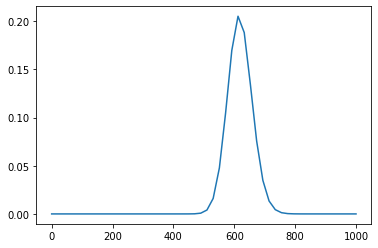

In [35]:
belief.plot()

## Quantifying Precision

We'll use the standard deviation as a measure of our precision.

In [36]:
(belief.mean(), belief.std())

(618.6942050450823, 40.08554296596485)

For a test with all questions having the same difficulty, precision depends strongly on the level of the test-taker.

In [ ]:
actual_abilities = np.linspace(200, 800)
results = pd.DataFrame(columns = ["ability", "poserior_std"])
series = pd.Series(index =actual_abilities, dtype="float", name="std")

for actual_ability in actual_abilities:
    belief, trace = simulate_test(actual_ability)
    series[actual_ability] = belief.std()

In [ ]:
plt.plot(series)

The data are noisy, but you can see that it is lowest around 600 and higher otherwise.

## Discriminatory Power

Another way to describe the performance of a test (rather than the test-taker) is to measure "discriminatory power"; which is the ability of test-takers to distinguish correctly between test-takers with different ability.

To measure discriminatory power, let's simulate the same person taking the test 100 times, and use the mean of the posterior distribution as their 'score'.

In [ ]:
def sample_posterior(actual_ability, iters):
    """ 
    Simulate multiple tests and compute posterior means 
    
    actual_ability: number
    iters: number of tests to simulate
    """
    scores = []
    
    for i in range(iters):
        belief, trace = simulate_test(actual_ability)
        score = belief.mean()
        scores.append(score)
        
    return np.array(scores)

sample_500 = sample_posterior(500, iters=100)
sample_600 = sample_posterior(600, iters=100)
sample_700 = sample_posterior(700, iters=100)
sample_800 = sample_posterior(800, iters=100)

from empiricaldist import Cdf

cdf_500 = Cdf.from_seq(sample_500)
cdf_600 = Cdf.from_seq(sample_600)
cdf_700 = Cdf.from_seq(sample_700)
cdf_800 = Cdf.from_seq(sample_800)

for cdf in [cdf_500, cdf_600, cdf_700, cdf_800]:
    cdf.plot()

Although there is some overlap, in general the discriminatory power is good.

In [ ]:
np.mean(sample_600 > sample_500)

In [ ]:
np.mean(sample_700 > sample_600)

In [ ]:
np.mean(sample_800 > sample_700)

## Actual Exercises

1. Modify `choose` so that it selects the difficulty based on $i$, the index of the question
2. Modify `choose` so that it selects the difficulty based on based on `belief`, which is the posterior distribution of the test-taker's ability

For both versions, run the simulation again to quantify the precision of the test and its discriminatory power

For the first version of `choose`, what is the ideal distribution of difficulties?

For the second version, what is the adaptive strategy that maximizes the precision of the test over the range of abilities?

In [ ]:
# choose
def choose(i, belief):
    num_questions = 51
    difficulties = np.linspace(200, 800, num_questions)
    return difficulties[i]

def choose(i, belief):
    return belief.mean()